**Outline of Steps**
    + Initialization
        + Download COCO detection data from http://cocodataset.org/#download
            + http://images.cocodataset.org/zips/train2014.zip <= train images
            + http://images.cocodataset.org/zips/val2014.zip <= validation images
            + http://images.cocodataset.org/annotations/annotations_trainval2014.zip <= train and validation annotations
        + Run this script to convert annotations in COCO format to VOC format
            + https://gist.github.com/chicham/6ed3842d0d2014987186#file-coco2pascal-py
        + Download pre-trained weights from https://pjreddie.com/darknet/yolo/
            + https://pjreddie.com/media/files/yolo.weights
        + Specify the directory of train annotations (train_annot_folder) and train images (train_image_folder)
        + Specify the directory of validation annotations (valid_annot_folder) and validation images (valid_image_folder)
        + Specity the path of pre-trained weights by setting variable *wt_path*
    + Construct equivalent network in Keras
        + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/yolo-voc.cfg
    + Load the pretrained weights
    + Perform training 
    + Perform detection on an image with newly trained weights
    + Perform detection on an video with newly trained weights

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"


# Initialization

In [2]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle as pkl
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes
import pandas as pd

%matplotlib inline

Using TensorFlow backend.


In [3]:
!python -V

Python 3.6.9 :: Anaconda, Inc.


In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [5]:
from sklearn.cluster import KMeans

In [6]:
# wt_path = 'yolov2.weights'                      
# train_image_folder = '/home/andy/data/coco/train2014/'
# train_annot_folder = '/Users/linglu/Downloads/annotations'
# valid_image_folder = '/Users/linglu/Code/COCO_folder/images/val2014/'
# valid_annot_folder = '/Users/linglu/Code/output_folder/'

In [7]:
# wt_path = 'yolov2.weights'                      
train_image_folder = 'data/20k_void_cheque_images/fake20k'
train_annot_folder = 'data/annotations'
valid_image_folder = 'data/20k_void_cheque_images/fake20k'
valid_annot_folder = 'data/annotations'

In [8]:
!ls -laht {train_image_folder} | head

total 95G
drwxrwxr-x 3 lou lou 4.0K Jul 29 12:23 ..
-rw-r--r-- 1 lou lou  81K Jul 29 11:03 fake_non_blank_9984.tiff
-rw-r--r-- 1 lou lou 207K Jul 29 11:03 fake_non_blank_9985.tiff
-rw-r--r-- 1 lou lou  89K Jul 29 11:03 fake_non_blank_9986.tiff
-rw-r--r-- 1 lou lou  30K Jul 29 11:03 fake_non_blank_9987.tiff
-rw-r--r-- 1 lou lou  38K Jul 29 11:03 fake_non_blank_9989.tiff
-rw-r--r-- 1 lou lou 519K Jul 29 11:03 fake_non_blank_9990.tiff
-rw-r--r-- 1 lou lou  65K Jul 29 11:03 fake_non_blank_9991.tiff
-rw-r--r-- 1 lou lou  24K Jul 29 11:03 fake_non_blank_9992.tiff
ls: write error: Broken pipe


In [9]:
import pandas as pd

labels_csv_path = 'data/20k_augmented_void_cheque_labels.csv'

labels = pd.read_csv(labels_csv_path)

labels.columns = ['_','path','top_left','x_y']

labels['label_box'] = labels[['top_left','x_y']].apply(lambda x: eval(x.top_left) + eval(x.x_y), axis=1)

#labels['path'] = labels['path'].apply(lambda x: os.path.join('/Users/linglu/Code/fic/', x))

def convert_label_to_coco(label, path):
    print(path)
    height, width = cv2.imread(path, 0).shape
    #print(path, height, width)
    sample = {'object': [{'name': 'cheque',
    'xmin': label[0],
    'ymin': label[1],
    'xmax': label[0] + label[2],
    'ymax': label[1] + label[3]},],
    'filename': path,
    'width': width,
    'height': height}
    
    return sample
  
    

def create_coco_labels(labels_df):
    labels = []
    for _, row in labels_df.iterrows():
        label = convert_label_to_coco(row['label_box'], row['path'])
        labels.append(label)
    return labels

coco_labels_path = 'data/coco_labels.pkl'
if os.path.exists(coco_labels_path):
    coco_labels = pkl.load(open(coco_labels_path, 'rb'))
else:
    coco_labels = create_coco_labels(labels)
    with open('data/coco_labels.pkl','wb') as coco_file:
        pkl.dump(coco_labels, coco_file)

In [10]:
GRID_H,  GRID_W  = 7 , 7

In [11]:
normalized_w_h = []

for coco in coco_labels:
    c = coco['object'][0]
    h = GRID_H * (c['ymax'] - c['ymin']) / coco['height']
    w = GRID_W * (c['xmax'] - c['xmin']) / coco['width']
    normalized_w_h.append([w, h])

In [12]:
X = np.stack(normalized_w_h)

In [13]:
X

array([[4.01446759, 2.70349386],
       [4.24268293, 3.1634349 ],
       [4.55      , 2.44598338],
       ...,
       [4.41145833, 2.76512456],
       [4.74646226, 1.92330918],
       [4.54811151, 2.55613426]])

In [14]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

(array([ 5740.,     0., 10506.,     0.,     0.,  1187.,     0.,  2200.,
            0.,   246.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

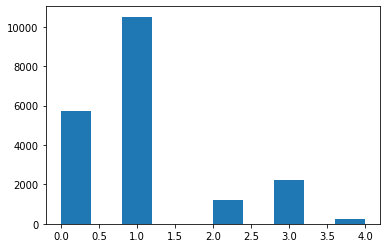

In [15]:
plt.hist(kmeans.labels_)

In [16]:
kmeans.cluster_centers_

array([[4.64223404, 3.26757458],
       [4.61472916, 1.63205159],
       [1.94749648, 3.50420219],
       [4.28785978, 2.59031526],
       [1.89731375, 5.68014595]])

In [17]:
kmeans.cluster_centers_.reshape(-1)

array([4.64223404, 3.26757458, 4.61472916, 1.63205159, 1.94749648,
       3.50420219, 4.28785978, 2.59031526, 1.89731375, 5.68014595])

In [18]:
LABELS = ['cheque', ]

IMAGE_H, IMAGE_W = 416, 416
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = kmeans.cluster_centers_.reshape(-1)

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 64
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = BATCH_SIZE

# Construct the network

In [19]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [20]:
tf.__version__

'1.12.0'

In [21]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

width = 16

# Layer 1
x = Conv2D(width, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(width * 2, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(width * 4, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(width * 2, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(width * 4, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(width * 8, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(width * 4, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(width * 8, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(width * 16, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(width * 8, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(width * 16, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(width * 8, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(width * 16, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(width * 32, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(width * 16, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(width * 32, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(width * 16, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(width * 32, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(width * 32, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(width * 32, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(width * 2, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(width * 32, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(2,2), padding='same', name='conv_23')(x)
print(x.shape, GRID_H * GRID_W * BOX * (4 + 1 + CLASS))
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

(?, 7, 7, 30) 1470


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 16) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Load pretrained weights

**Load the weights originally provided by YOLO**

**Randomize weights of the last layer**

# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [42]:
def custom_loss(y_true, y_pred):
    y_true = tf.Print(y_true, [tf.shape(y_true), tf.shape(true_boxes)],'y_true, y_pred', summarize= 20)
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    
    print('pred_area_sh', pred_areas.shape)
    print('int_sh', intersect_areas.shape)
    print('true_area', true_areas.shape)

    union_areas = pred_areas + true_areas - intersect_areas
    print('un_area_1_sh', union_areas.shape)
    
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    print('wh',intersect_wh.shape)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    
    print('pred_area_sh2', pred_areas.shape)
    print('int_sh2', intersect_areas.shape)
    print('true_area2', true_areas.shape)


    union_areas = pred_areas + true_areas - intersect_areas

    print('int',intersect_areas.shape)
    print('union',union_areas.shape)
    
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.95) * tf.to_float(pred_box_conf > 0.95))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/ (nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [24]:
def compile_model(model, custom_loss):
    optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss=custom_loss, optimizer=optimizer)
    return model

In [25]:
m = compile_model(model, custom_loss)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

pred_area_sh (?, 7, 7, 5)
int_sh (64, 7, 7, 5)
true_area (?, ?, ?, ?)
un_area_1_sh (64, 7, 7, 5)
wh (64, 7, 7, 5, 64, 2)
pred_area_sh2 (?, 7, 7, 5, 1)
int_sh2 (64, 7, 7, 5, 64)
true_area2 (?, 1, 1, 1,

**Parse the annotations to construct train generator and validation generator**

In [26]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : BATCH_SIZE,
}

In [27]:
def normalize(image):
    return image / 255.

In [28]:
def normalize_single_image(img):
    return (img - np.mean(img)) / np.sqrt(np.var(img) + 0.0001)

In [29]:
train_batch = BatchGenerator(coco_labels, generator_config, norm=normalize_single_image)


In [30]:
optimizer = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer,  metrics=['acc'])

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 50, 
                    verbose          = 1,
                    #validation_data  = train_batch,
                    #validation_steps = len(train_batch),
                    max_queue_size   = 13)

pred_area_sh (?, 7, 7, 5)
int_sh (64, 7, 7, 5)
true_area (?, ?, ?, ?)
un_area_1_sh (64, 7, 7, 5)
wh (64, 7, 7, 5, 64, 2)
pred_area_sh2 (?, 7, 7, 5, 1)
int_sh2 (64, 7, 7, 5, 64)
true_area2 (?, 1, 1, 1, 64)
int (64, 7, 7, 5, 64)
union (64, 7, 7, 5, 64)
Epoch 1/50
311/311 [==============================] - 2475s 8s/step - loss: 10.1855 - acc: 0.2055
Epoch 2/50
311/311 [==============================] - 2501s 8s/step - loss: 6.7289 - acc: 0.1941
Epoch 3/50
311/311 [==============================] - 2459s 8s/step - loss: 5.3003 - acc: 0.1801
Epoch 4/50
311/311 [==============================] - 2550s 8s/step - loss: 3.4868 - acc: 0.1942
Epoch 5/50
311/311 [==============================] - 2475s 8s/step - loss: 1.6994 - acc: 0.1957
Epoch 6/50
311/311 [==============================] - 2547s 8s/step - loss: 0.9735 - acc: 0.1991
Epoch 7/50
311/311 [==============================] - 2551s 8s/step - loss: 0.6885 - acc: 0.1958
Epoch 8/50
311/311 [==============================] - 2494s 8s/step -

KeyboardInterrupt: 

In [31]:
model.save('Initial_with_cluster_anchor_wider_new_normal.h5')

In [44]:
optimizer = Adam(lr=4e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer,  metrics=['acc'])
model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 60, 
                    verbose          = 1,
                    #validation_data  = train_batch,
                    #validation_steps = len(train_batch),
                    max_queue_size   = 13)

pred_area_sh (?, 7, 7, 5)
int_sh (64, 7, 7, 5)
true_area (?, ?, ?, ?)
un_area_1_sh (64, 7, 7, 5)
wh (64, 7, 7, 5, 64, 2)
pred_area_sh2 (?, 7, 7, 5, 1)
int_sh2 (64, 7, 7, 5, 64)
true_area2 (?, 1, 1, 1, 64)
int (64, 7, 7, 5, 64)
union (64, 7, 7, 5, 64)
Epoch 1/60
311/311 [==============================] - 2003s 6s/step - loss: 0.0298 - acc: 0.3689
Epoch 2/60
311/311 [==============================] - 2028s 7s/step - loss: 0.0329 - acc: 0.3066
Epoch 3/60
311/311 [==============================] - 2100s 7s/step - loss: 0.0139 - acc: 0.3242
Epoch 4/60
311/311 [==============================] - 2075s 7s/step - loss: 0.0117 - acc: 0.3397
Epoch 5/60
311/311 [==============================] - 2009s 6s/step - loss: 0.0095 - acc: 0.3365
Epoch 6/60
311/311 [==============================] - 2012s 6s/step - loss: 0.0082 - acc: 0.3419
Epoch 7/60
311/311 [==============================] - 2111s 7s/step - loss: 0.0078 - acc: 0.3461
Epoch 8/60
311/311 [==============================] - 2071s 7s/step - 

KeyboardInterrupt: 

In [45]:
model.save('Initial_with_cluster_anchor_wider_new_normal_higher_lr.h5')

In [53]:
!cp 'Initial_with_cluster_anchor_wider_new_normal_higher_lr.h5' 'cheque_detector_aug_7.h5'

In [54]:
!pwd

/raid/void_cheque_workspace


In [46]:
dev_path = '/raid/void_cheque_data/dev_dataset'
void_data_df = pd.read_csv('/raid/void_cheque_data/dev_dataset/eft_image.txt')
env_ids = void_data_df['EnvId'].apply(lambda x: x.split(','))
void_data_df['EnvelopeIds'] = env_ids

In [50]:
model.load_weights('Initial_with_cluster_anchor_wider_new_normal_higher_lr.h5')

In [48]:
def test_image(image, obj_threshold=0.5, draw=True):
    dummy_array = np.zeros((1,1,1,1, TRUE_BOX_BUFFER, 4))

    plt.figure(figsize=(10,10))

    input_image = cv2.resize(image, (416, 416))
    input_image = normalize_single_image(input_image) #input_image / 255.
    
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=obj_threshold,#57,#OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    
    if len(boxes) > 0 and draw:
        image = draw_boxes(image, boxes, labels=LABELS)

        plt.imshow(image[:,:,::-1]); plt.show()

    return boxes

5045448 62532431
/raid/void_cheque_data/dev_dataset/images/62532431.tiff
[]
[]
[]
[]
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

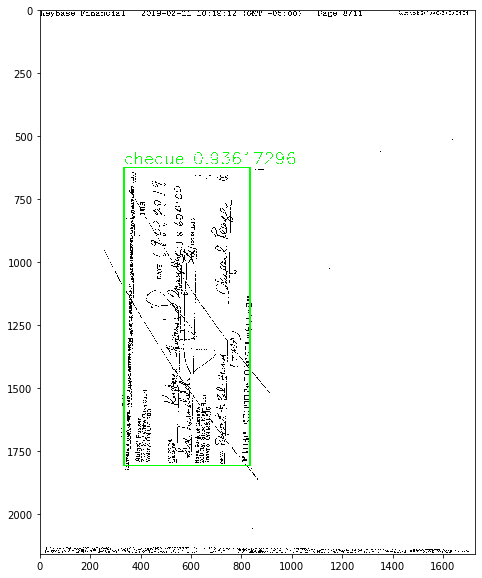

[]
[]
[]
5046032 62191241
/raid/void_cheque_data/dev_dataset/images/62191241.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

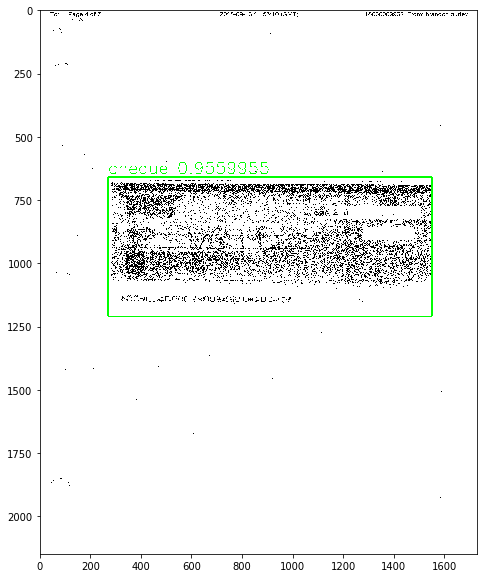

[]
[]
[]
5048822 62595080
/raid/void_cheque_data/dev_dataset/images/62595080.tiff
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

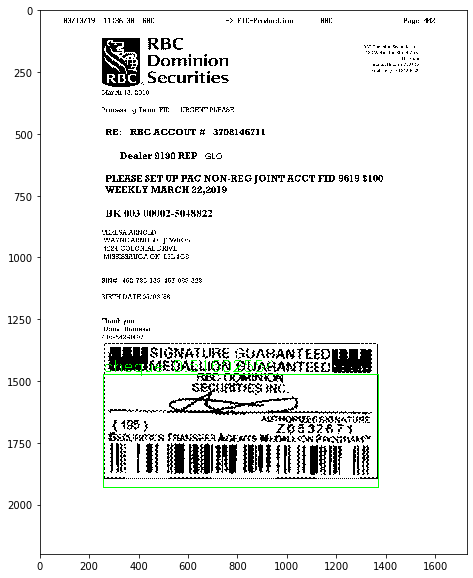

5048822 62258914
/raid/void_cheque_data/dev_dataset/images/62258914.tiff
[]
[]
5054135 54268211
/raid/void_cheque_data/dev_dataset/images/54268211.tiff
[]
[]
5055371 62288969
/raid/void_cheque_data/dev_dataset/images/62288969.tiff
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

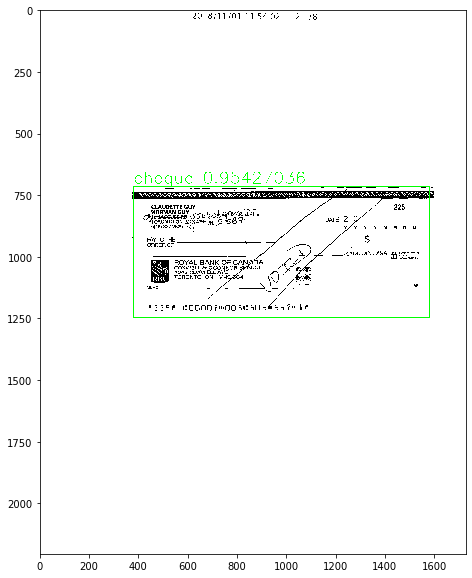

[]
[]
[]
[]
[]
[]
5064779 59843110
/raid/void_cheque_data/dev_dataset/images/59843110.tiff
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


/home/lou/anaconda3/envs/yolo_detector/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


[]
[]
[]
[]
5070552 55527398
/raid/void_cheque_data/dev_dataset/images/55527398.tiff


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

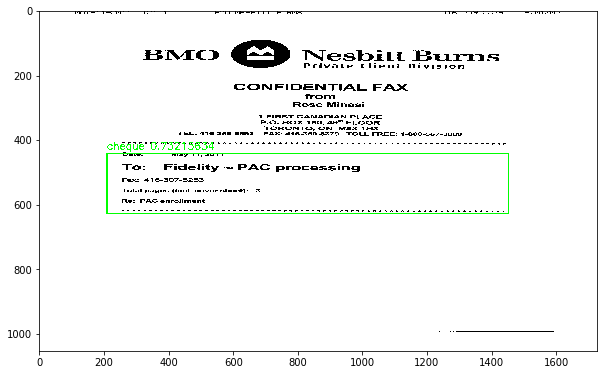

[]


<Figure size 720x720 with 0 Axes>

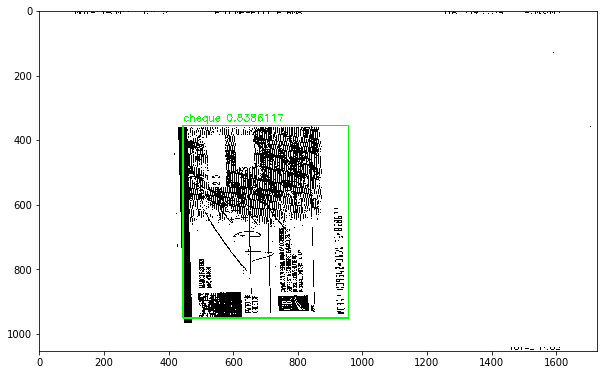

5070552 59809683
/raid/void_cheque_data/dev_dataset/images/59809683.tiff


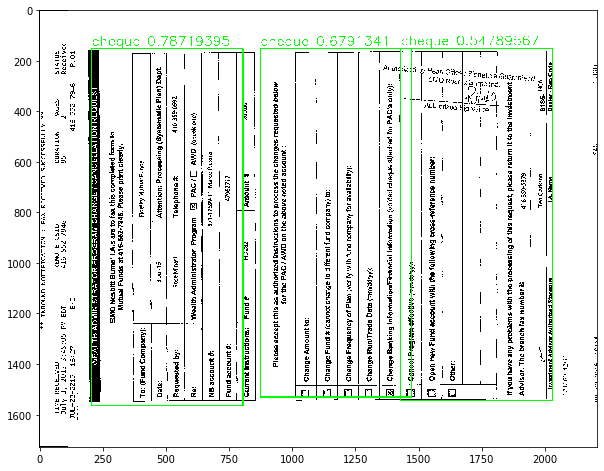

[<utils.BoundBox object at 0x7f3630da92e8>, <utils.BoundBox object at 0x7f3630e4f0f0>, <utils.BoundBox object at 0x7f3630e40b70>]
[]
5070651 62051292
/raid/void_cheque_data/dev_dataset/images/62051292.tiff
[]
5070651 62051326
/raid/void_cheque_data/dev_dataset/images/62051326.tiff
[]
5070651 58704118
/raid/void_cheque_data/dev_dataset/images/58704118.tiff
[]
[]
5070651 58688902
/raid/void_cheque_data/dev_dataset/images/58688902.tiff
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

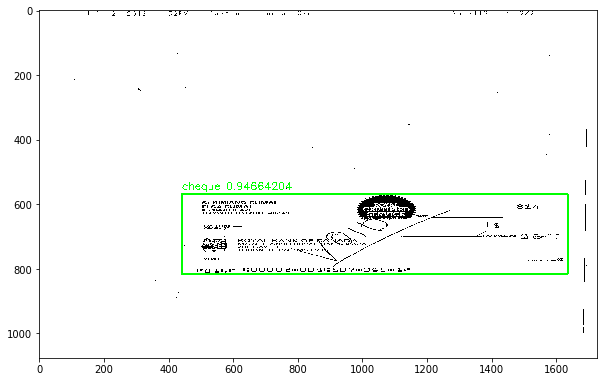

5070651 61080136
/raid/void_cheque_data/dev_dataset/images/61080136.tiff
[]
5074786 60404109
/raid/void_cheque_data/dev_dataset/images/60404109.tiff
[]
[]
[]
[]
[]
[]
[]
5076607 61658934
/raid/void_cheque_data/dev_dataset/images/61658934.tiff
[]
[]
5077052 59839917
/raid/void_cheque_data/dev_dataset/images/59839917.tiff
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

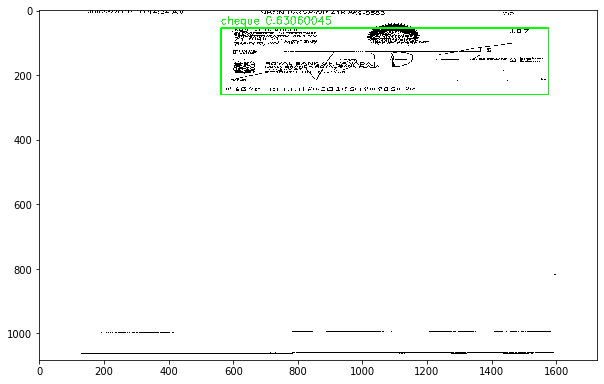

[]
5080379 61655389
/raid/void_cheque_data/dev_dataset/images/61655389.tiff
[]
[]
5080379 62165341
/raid/void_cheque_data/dev_dataset/images/62165341.tiff
[]
5080379 61511611
/raid/void_cheque_data/dev_dataset/images/61511611.tiff
[]
[]
5080379 61278373
/raid/void_cheque_data/dev_dataset/images/61278373.tiff
[]
[]
5081740 62020941
/raid/void_cheque_data/dev_dataset/images/62020941.tiff
[]
[]
[]
[]
5086988 60458701
/raid/void_cheque_data/dev_dataset/images/60458701.tiff
[]
5092846 53863502
/raid/void_cheque_data/dev_dataset/images/53863502.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

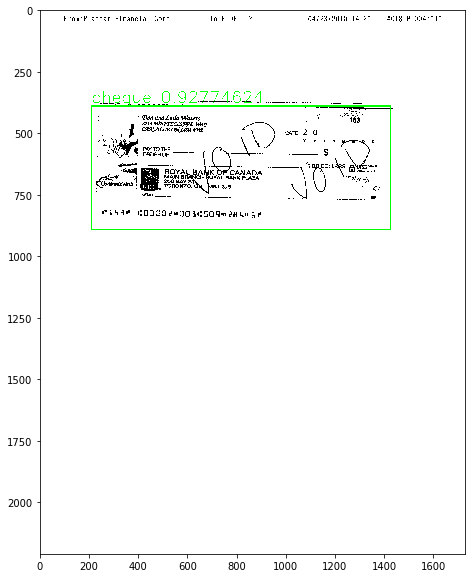

[]
[]
[]
[]
[]
[]
5096607 62441567
/raid/void_cheque_data/dev_dataset/images/62441567.tiff
[]
5096607 61863235
/raid/void_cheque_data/dev_dataset/images/61863235.tiff
[]
[]
[]
[]
[]
[]
[]
[]
5133277 62079335
/raid/void_cheque_data/dev_dataset/images/62079335.tiff
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

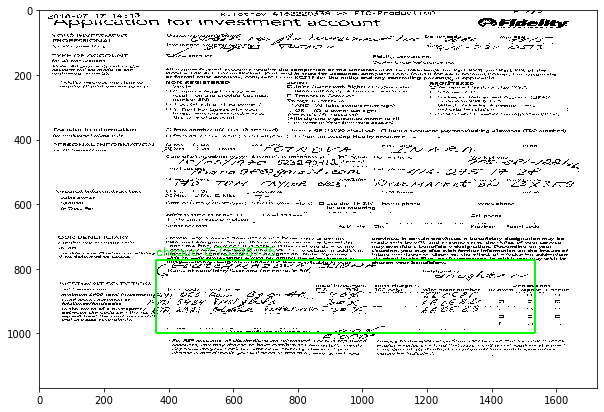

[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

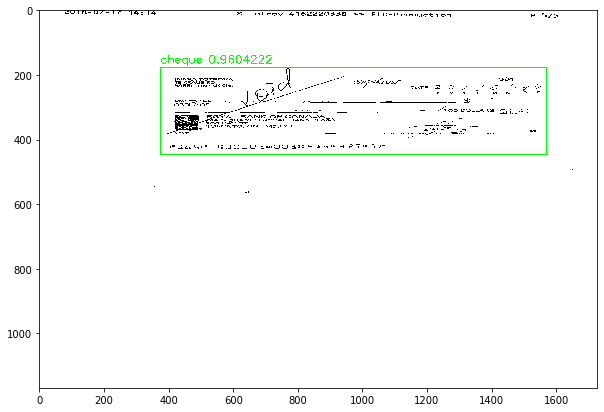

5140728 60778661
/raid/void_cheque_data/dev_dataset/images/60778661.tiff
[]
[]
[]
[]
[]
[]
5149190 61339955
/raid/void_cheque_data/dev_dataset/images/61339955.tiff
[]
5149190 61339964
/raid/void_cheque_data/dev_dataset/images/61339964.tiff
[]
5149190 62401389
/raid/void_cheque_data/dev_dataset/images/62401389.tiff
[]
[]
[]
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

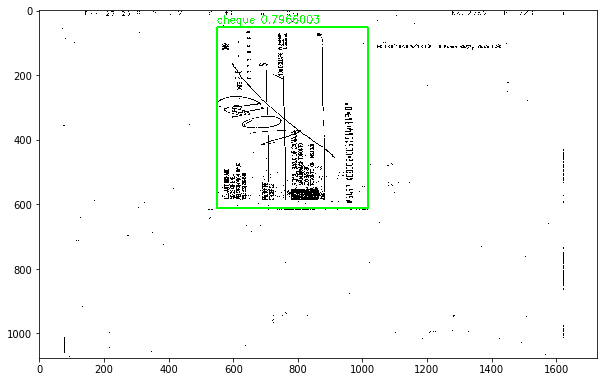

[]
5154240 62508971
/raid/void_cheque_data/dev_dataset/images/62508971.tiff
[]
[]
5163399 62606617
/raid/void_cheque_data/dev_dataset/images/62606617.tiff
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
5163431 62144853
/raid/void_cheque_data/dev_dataset/images/62144853.tiff
[]
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

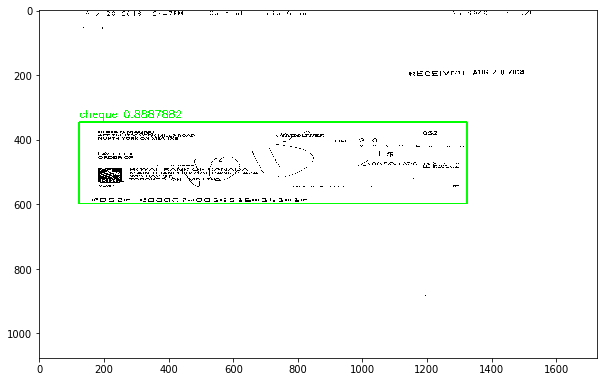

5166160 62308093
/raid/void_cheque_data/dev_dataset/images/62308093.tiff
[]


<Figure size 720x720 with 0 Axes>

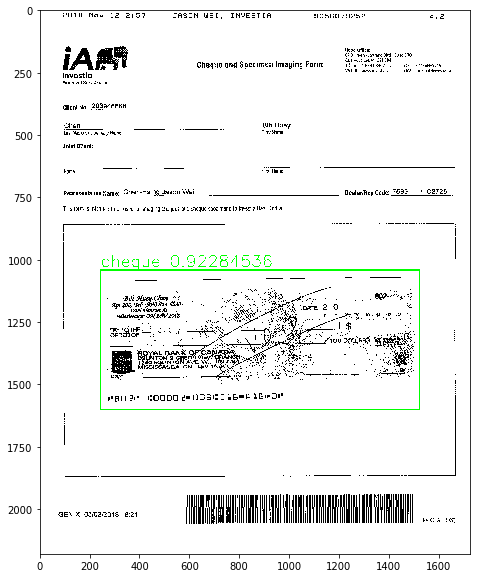

5166160 59892221
/raid/void_cheque_data/dev_dataset/images/59892221.tiff
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

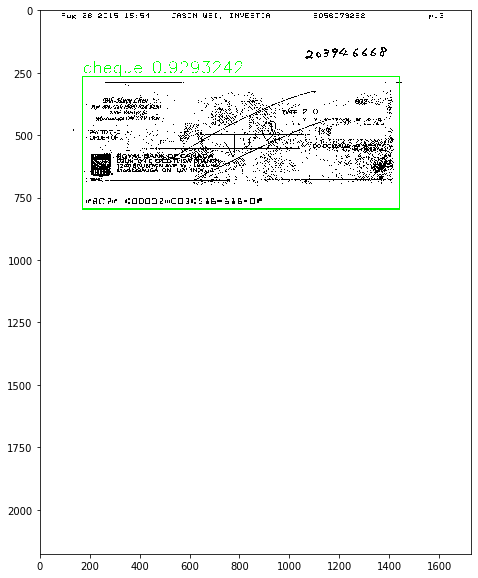

5169750 57260588
/raid/void_cheque_data/dev_dataset/images/57260588.tiff
[]
[]
5174750 62241857
/raid/void_cheque_data/dev_dataset/images/62241857.tiff
[]
[]
[]
[]
[]
[]
[]
[]
[]
5185566 61522013
/raid/void_cheque_data/dev_dataset/images/61522013.tiff
[]
[]
[]
[]
[]
[]
[]
[]
5190053 61166021
/raid/void_cheque_data/dev_dataset/images/61166021.tiff
[]
[]
5190053 61808388
/raid/void_cheque_data/dev_dataset/images/61808388.tiff
[]
[]
5190053 60095688
/raid/void_cheque_data/dev_dataset/images/60095688.tiff
[]
[]
5190053 61807108
/raid/void_cheque_data/dev_dataset/images/61807108.tiff
[]
[]
5200134 59720837
/raid/void_cheque_data/dev_dataset/images/59720837.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

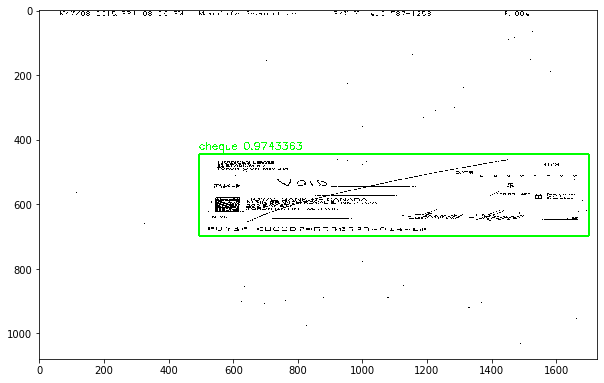

5213194 62765216
/raid/void_cheque_data/dev_dataset/images/62765216.tiff
[]
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

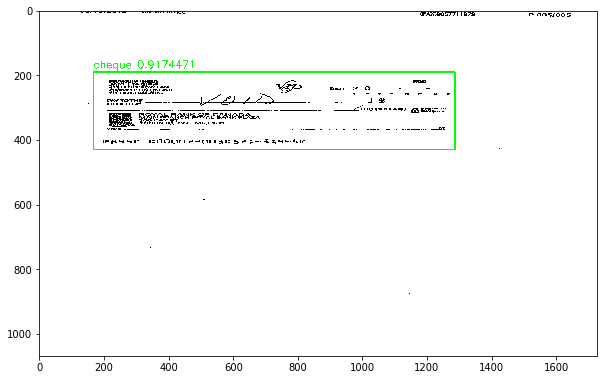

5219688 61886111
/raid/void_cheque_data/dev_dataset/images/61886111.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

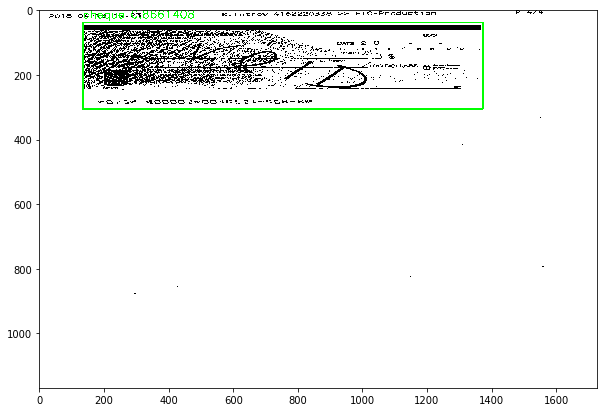

5235981 56068727
/raid/void_cheque_data/dev_dataset/images/56068727.tiff
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

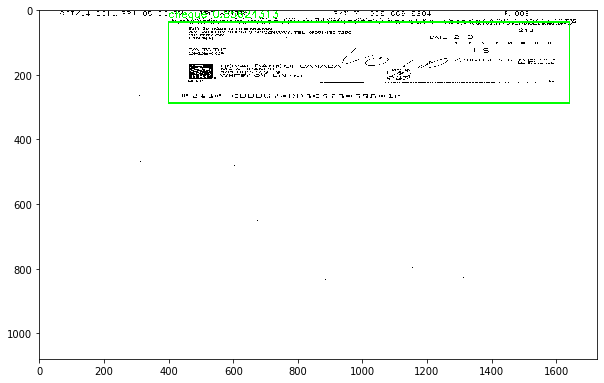

5235981 62681064
/raid/void_cheque_data/dev_dataset/images/62681064.tiff
[]
[]
[]
[]
[]
5243084 61604851
/raid/void_cheque_data/dev_dataset/images/61604851.tiff
[]
[]
5256326 57625383
/raid/void_cheque_data/dev_dataset/images/57625383.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

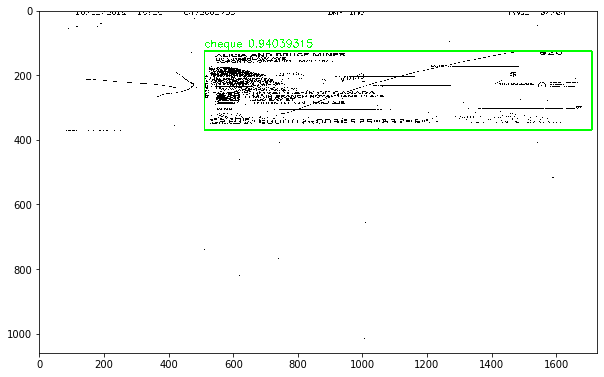

5268867 61487422
/raid/void_cheque_data/dev_dataset/images/61487422.tiff
[]
[]
5272646 62549524
/raid/void_cheque_data/dev_dataset/images/62549524.tiff
[]
[]
5272646 61913797
/raid/void_cheque_data/dev_dataset/images/61913797.tiff
[]
[]
[]
[]
5275722 62538487
/raid/void_cheque_data/dev_dataset/images/62538487.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

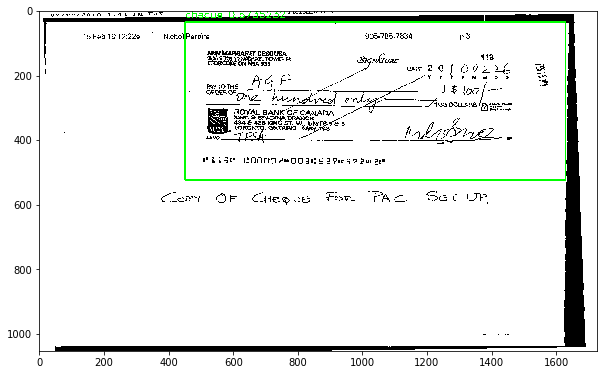

5276589 61395393
/raid/void_cheque_data/dev_dataset/images/61395393.tiff
[]
5276589 61395603
/raid/void_cheque_data/dev_dataset/images/61395603.tiff
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

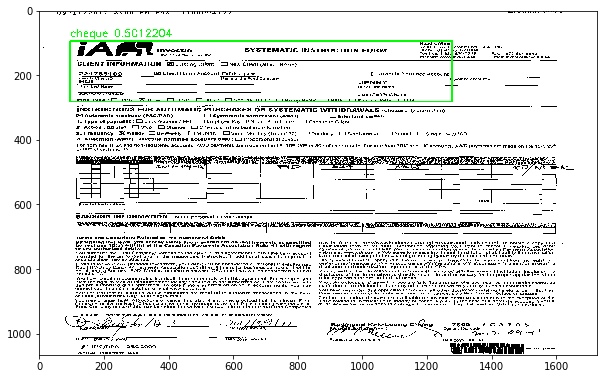

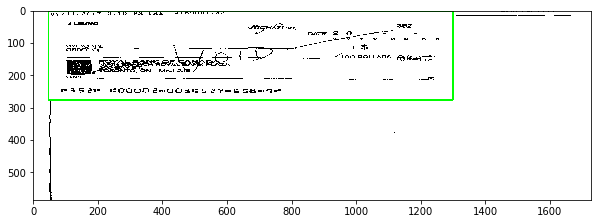

5277306 62097843
/raid/void_cheque_data/dev_dataset/images/62097843.tiff
[]
[]
[]
[]
[]
[]
[]
[]
[]
5290481 62388348
/raid/void_cheque_data/dev_dataset/images/62388348.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

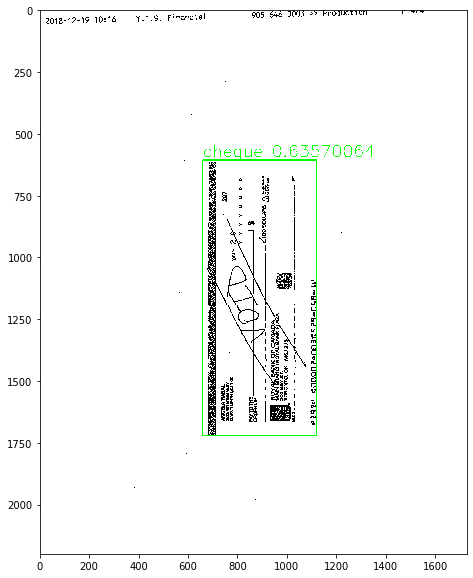

5290606 59257551
/raid/void_cheque_data/dev_dataset/images/59257551.tiff
[]
[]
5301297 52533702
/raid/void_cheque_data/dev_dataset/images/52533702.tiff
[]
[]
[]
[]
[]
[]
5304829 61752761
/raid/void_cheque_data/dev_dataset/images/61752761.tiff
[]
[]
[]
5311345 61702181
/raid/void_cheque_data/dev_dataset/images/61702181.tiff
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
5312384 61476179
/raid/void_cheque_data/dev_dataset/images/61476179.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

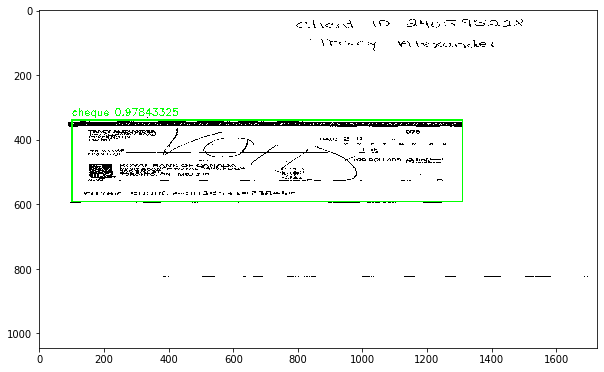

[]
[]
5322961 61487626
/raid/void_cheque_data/dev_dataset/images/61487626.tiff
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

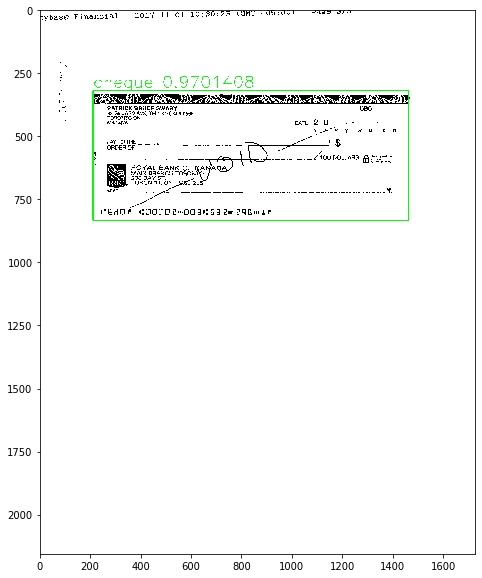

5323993 62558029
/raid/void_cheque_data/dev_dataset/images/62558029.tiff
[]
5323993 61565771
/raid/void_cheque_data/dev_dataset/images/61565771.tiff
[]
[]
[]
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

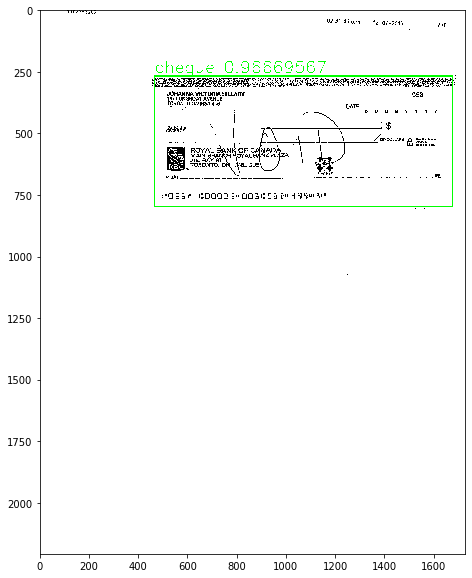

[]
5330709 57518472
/raid/void_cheque_data/dev_dataset/images/57518472.tiff
[]
[]
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

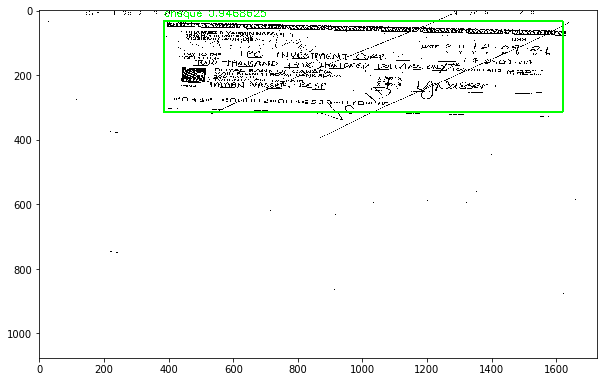

[]
[]
[]
[]
5330873 59426334
/raid/void_cheque_data/dev_dataset/images/59426334.tiff
[]
[]
[]
[]
[]
[]
5334669 61204730
/raid/void_cheque_data/dev_dataset/images/61204730.tiff
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

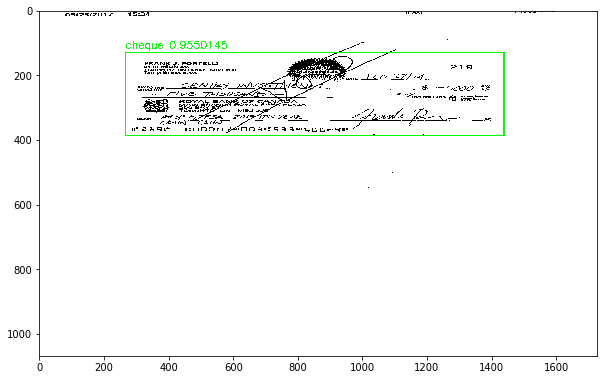

5334669 62553471
/raid/void_cheque_data/dev_dataset/images/62553471.tiff
[]
5334669 61729812
/raid/void_cheque_data/dev_dataset/images/61729812.tiff
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
5336430 62541446
/raid/void_cheque_data/dev_dataset/images/62541446.tiff
[]
[]
5336430 50233632
/raid/void_cheque_data/dev_dataset/images/50233632.tiff
[]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

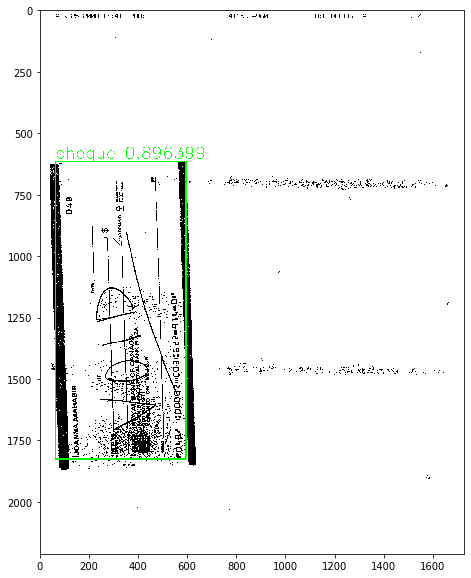

In [52]:
max_num_per_acct = 2
for index, row in void_data_df.head(450).tail(50).iterrows():
    bank_account = row['BankAcct']
    for i, env_id in enumerate(row['EnvelopeIds']):
        print(bank_account, env_id)
        p = os.path.join(dev_path, 'images', f'{env_id}.tiff')
        if not os.path.exists(p):
            print(f'File {p} does not exist')
            continue
        ret, images = cv2.imreadmulti(p)
        print(p)
        for i, im in enumerate(images):
            boxes = test_image(im)
            print(boxes)
        """if not os.path.exists(p):
            print(f'File {p} does not exist')
            continue
        
        ret, images = cv2.imreadmulti(p, flags=0)
        print(p)
        for i, im in enumerate(images):
            print(im.shape)
            plt.imshow(im); plt.show()"""
        if i > max_num_per_acct:
            break

In [ ]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

**Setup a few callbacks and start the training**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [ ]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'coco_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'coco_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

# Perform detection on image

In [ ]:
ls -l {train_image_folder}| tail

In [ ]:
impath = os.path.join(train_image_folder, 'fake_non_blank_9990.tiff')

In [ ]:
impath = os.path.join(train_image_folder, 'fake_non_blank_9993.tiff')

In [ ]:
from PIL import Image

In [ ]:
Image.open(impath)

In [ ]:
ls {impath}

In [ ]:
def test_image(impath):
    image = cv2.imread(impath)
    dummy_array = np.zeros((1,1,1,1, TRUE_BOX_BUFFER, 4))

    plt.figure(figsize=(10,10))

    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.57,#OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    
    image = draw_boxes(image, boxes, labels=LABELS)

    plt.imshow(image[:,:,::-1]); plt.show()

In [ ]:
test_image(impath)

# Perform detection on video

In [ ]:
model.load_weights("weights_coco.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [ ]:
video_inp = '../basic-yolo-keras/images/phnom_penh.mp4'
video_out = '../basic-yolo-keras/images/phnom_penh_bbox.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.3,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)

    video_writer.write(np.uint8(image))
    
video_reader.release()
video_writer.release()  